# Sequential Parameter Optimization
## `river` Hyperparameter Tuning: Evaluation

See: [https://riverml.xyz/0.15.0/examples/batch-to-online/](https://riverml.xyz/0.15.0/examples/batch-to-online/)

In [1]:
pip list | grep spotPython

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotRiver

## 1 The Data

In [3]:
from sklearn import datasets

# Load the data
dataset = datasets.load_breast_cancer()
X, y = dataset.data, dataset.target

In [4]:
from pyspotstream.datasets import fetch_opm
ds = fetch_opm(include_categorical=False, data_home="data", return_X_y=True)

## 2.1 Batch Machine Learning with Sklearn

In [5]:

from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing


# Define the steps of the model
sk_model = pipeline.Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LogisticRegression(solver='lbfgs'))
])

# Define a deterministic cross-validation procedure
cv = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

# Compute the MSE values
scorer = metrics.make_scorer(metrics.roc_auc_score)
scores = model_selection.cross_val_score(sk_model, X, y, scoring=scorer, cv=cv)

# Display the average score and it's standard deviation
print(f'ROC AUC: {scores.mean():.3f} (± {scores.std():.3f})')

ROC AUC: 0.975 (± 0.011)


## 2.2 Batch Machine Learning with River's `compat` Wrapper

* We can train a river model, e.g., LogisticRegression, in an OML manner:
  * the model is trained on single instances and not on the whole data set.

In [6]:
from river import linear_model
from river import compat
from river import compose
from river import preprocessing

# We define a Pipeline, exactly like we did earlier for sklearn 
rv_model = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('log_reg', linear_model.LogisticRegression())
)

# We make the Pipeline compatible with sklearn
# learn_one is called for each observation
rv2sk_model = compat.convert_river_to_sklearn(rv_model)



* Now we can apply sklearn's methods to the wrapped river model
* We compute the CV scores using the same CV scheme and the same scoring
 1. If sklearn's fit is called, then:
   Fit with one pass of the dataset portion is called
   learn_one is called for each observation
 2. If sklearn's predict s called, then:
   A prediction is made for each observation, the same (fitted) model is used,
   i.e., the model is not updated

In [7]:

scores = model_selection.cross_val_score(rv2sk_model, X, y, scoring=scorer, cv=cv)

# Display the average score and it's standard deviation
print(f'ROC AUC: {scores.mean():.3f} (± {scores.std():.3f})')

ROC AUC: 0.964 (± 0.016)


## 3.1 Mini Batch for River Models

In [8]:
from river import linear_model
from river import compose
from river import preprocessing
from river import stream
import pandas as pd


rv_model = compose.Pipeline(
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.Perceptron())
)

names = ["Assessed Value", "Sale Amount", "Sales Ratio"]

for x in pd.read_csv("data/opm_2001-2020.csv", usecols=names, chunksize=int(985862/10), nrows=985862, header=0):
    y = x.pop("Assessed Value")
    y_pred = rv_model.predict_proba_many(x)
    rv_model.learn_many(x, y)



# Plot Performance for HTs

* See [https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/](https://riverml.xyz/0.15.0/recipes/on-hoeffding-trees/)

In [9]:
import matplotlib.pyplot as plt
import datetime as dt

from river import datasets
from river import evaluate
from river import metrics
from river import preprocessing  # we are going to use that later
from river.datasets import synth  # we are going to use some synthetic datasets too
from river import tree

In [10]:
def plot_performance(dataset, metric, models):
    metric_name = metric.__class__.__name__

    # To make the generated data reusable
    dataset = list(dataset)
    fig, ax = plt.subplots(figsize=(10, 5), nrows=3, dpi=300)
    for model_name, model in models.items():
        step = []
        error = []
        r_time = []
        memory = []

        for checkpoint in evaluate.iter_progressive_val_score(
            dataset, model, metric, measure_time=True, measure_memory=True, step=100
        ):
            step.append(checkpoint["Step"])
            error.append(checkpoint[metric_name].get())

            # Convert timedelta object into seconds
            r_time.append(checkpoint["Time"].total_seconds())
            # Make sure the memory measurements are in MB
            raw_memory = checkpoint["Memory"]
            memory.append(raw_memory * 2**-20)

        ax[0].plot(step, error, label=model_name)
        ax[1].plot(step, r_time, label=model_name)
        ax[2].plot(step, memory, label=model_name)

    ax[0].set_ylabel(metric_name)
    ax[1].set_ylabel('Time (seconds)')
    ax[2].set_ylabel('Memory (MB)')
    ax[2].set_xlabel('Instances')

    ax[0].grid(True)
    ax[1].grid(True)
    ax[2].grid(True)

    ax[0].legend(
        loc='upper center', bbox_to_anchor=(0.5, 1.25),
        ncol=3, fancybox=True, shadow=True
    )
    plt.tight_layout()
    plt.close()

    return fig

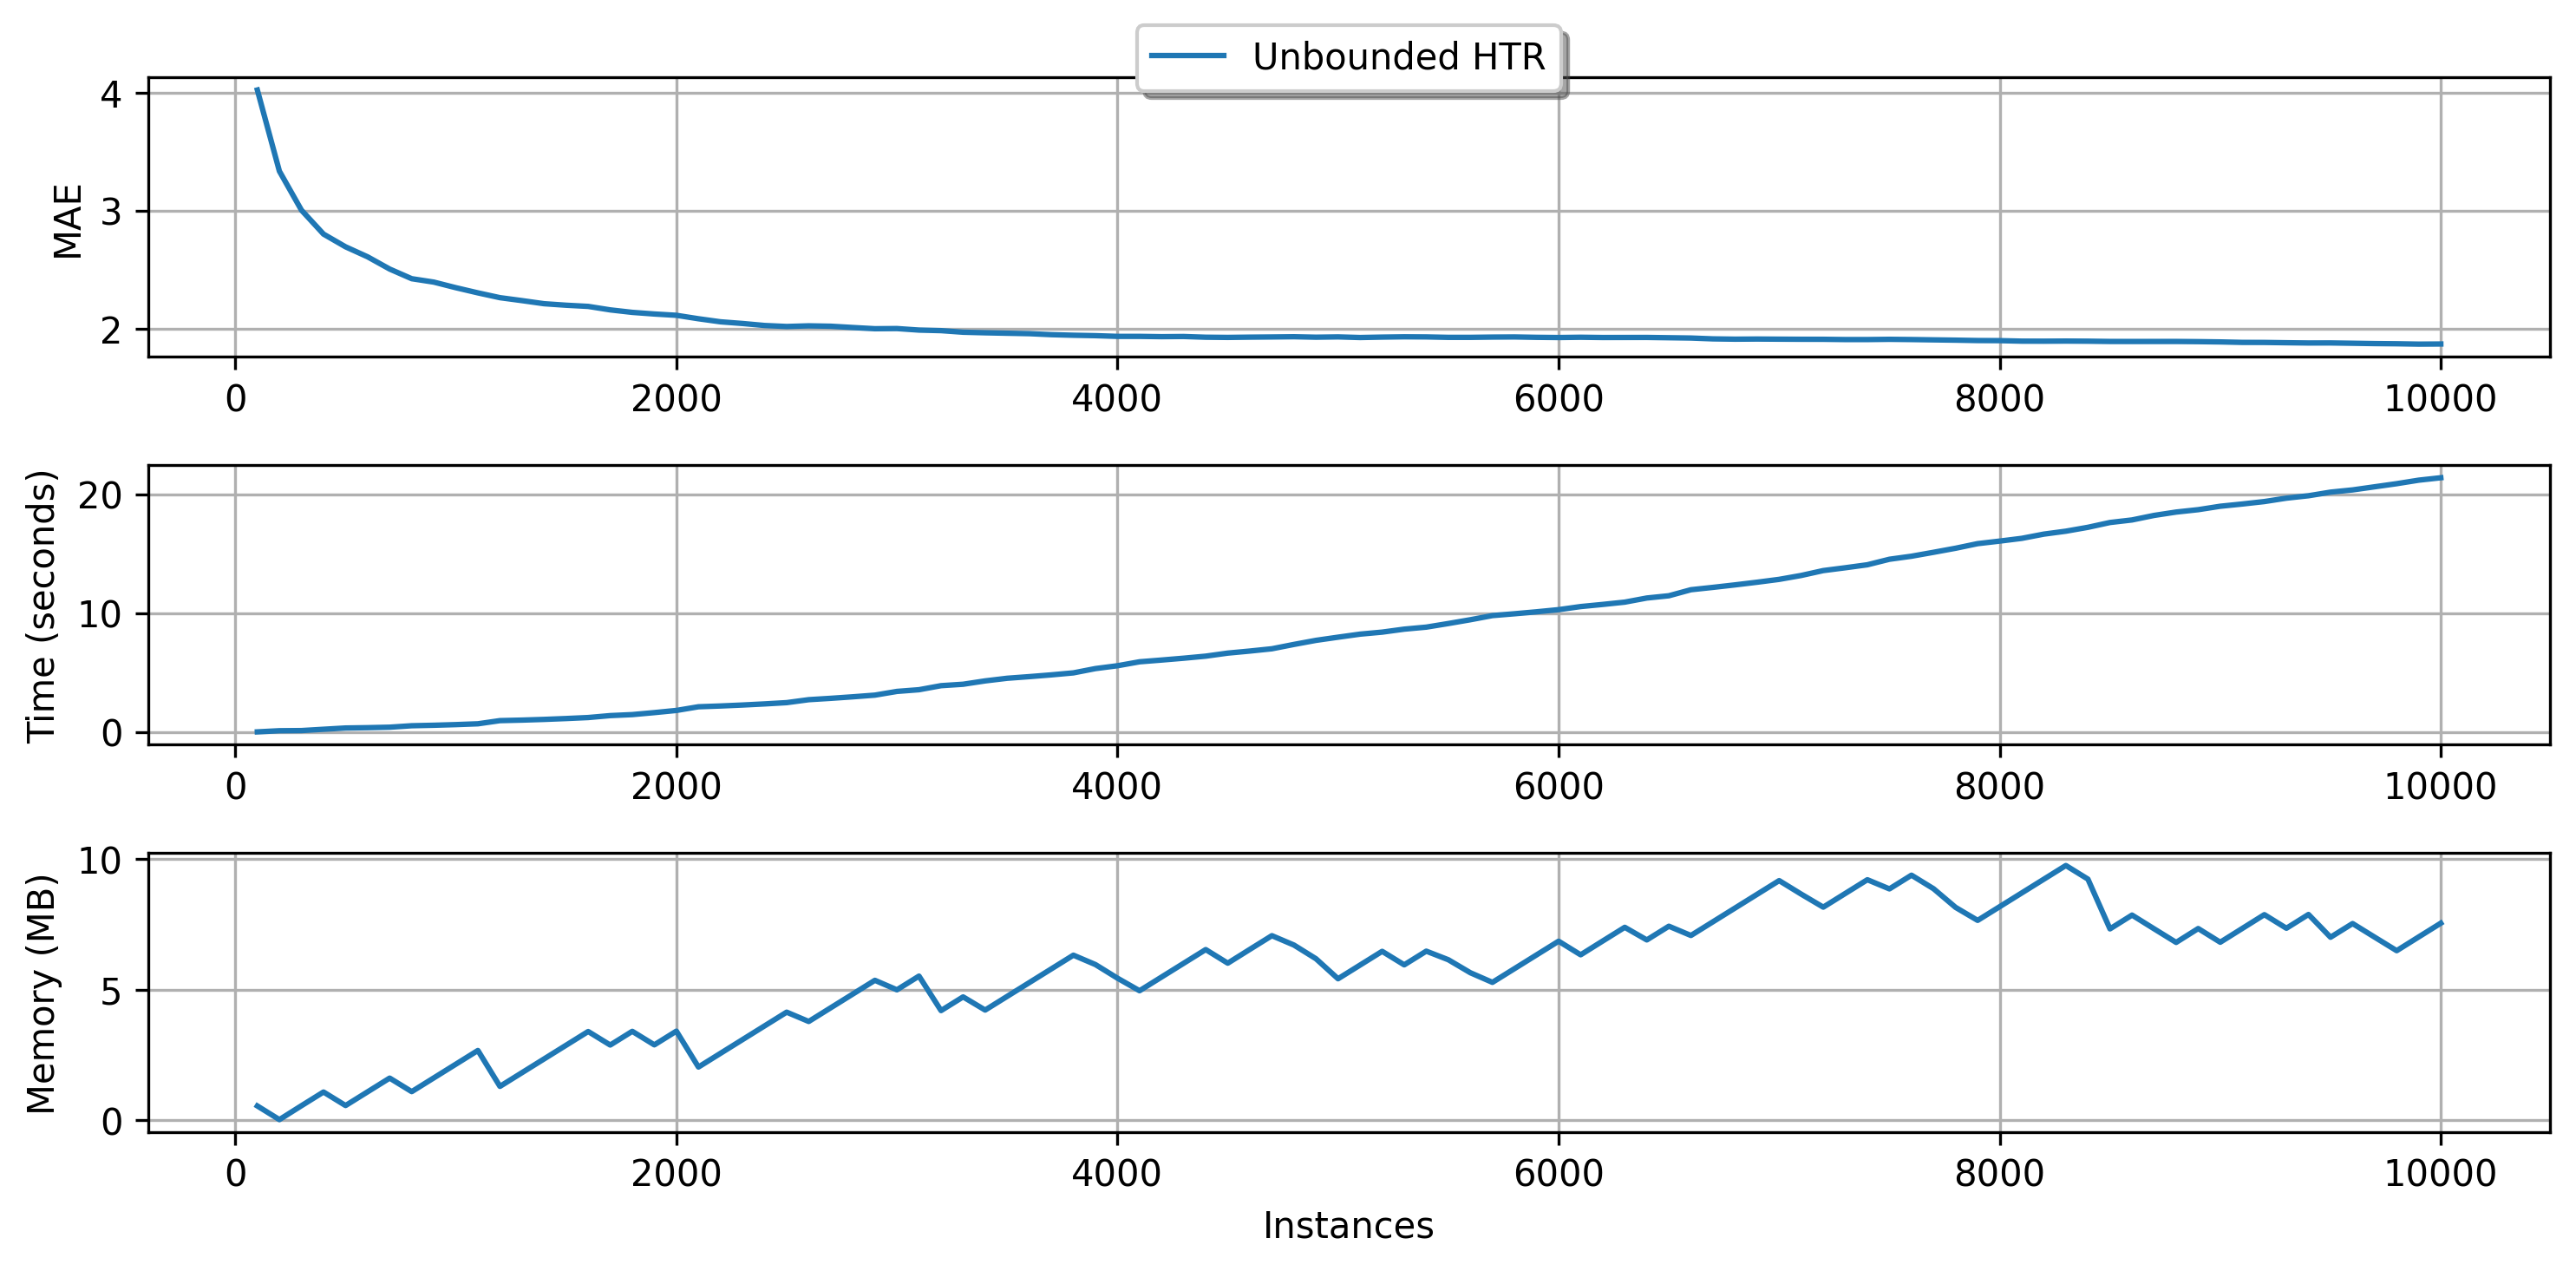

In [11]:
plot_performance(
    dataset = synth.Friedman(seed=42).take(10_000),
    metric = metrics.MAE(),
    models =
    {
        "Unbounded HTR": (
            preprocessing.StandardScaler() |
            tree.HoeffdingTreeRegressor(splitter=tree.splitter.EBSTSplitter())
        )
    }
)

In [12]:
from spotRiver.evaluation.eval_oml import eval_oml_iter_progressive
from spotRiver.evaluation.eval_oml import plot_oml_iter_progressive

In [13]:
res_1 = eval_oml_iter_progressive(
    dataset = synth.Friedman(seed=42).take(10_000),
    metric = metrics.MAE(),
    models =
    {
        "HTR + E-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.EBSTSplitter()
            )
        ),
        "HTR + TE-BST": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.TEBSTSplitter()
            )
        ),
        "HTR + QO": (
            preprocessing.StandardScaler() | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),

    }
)

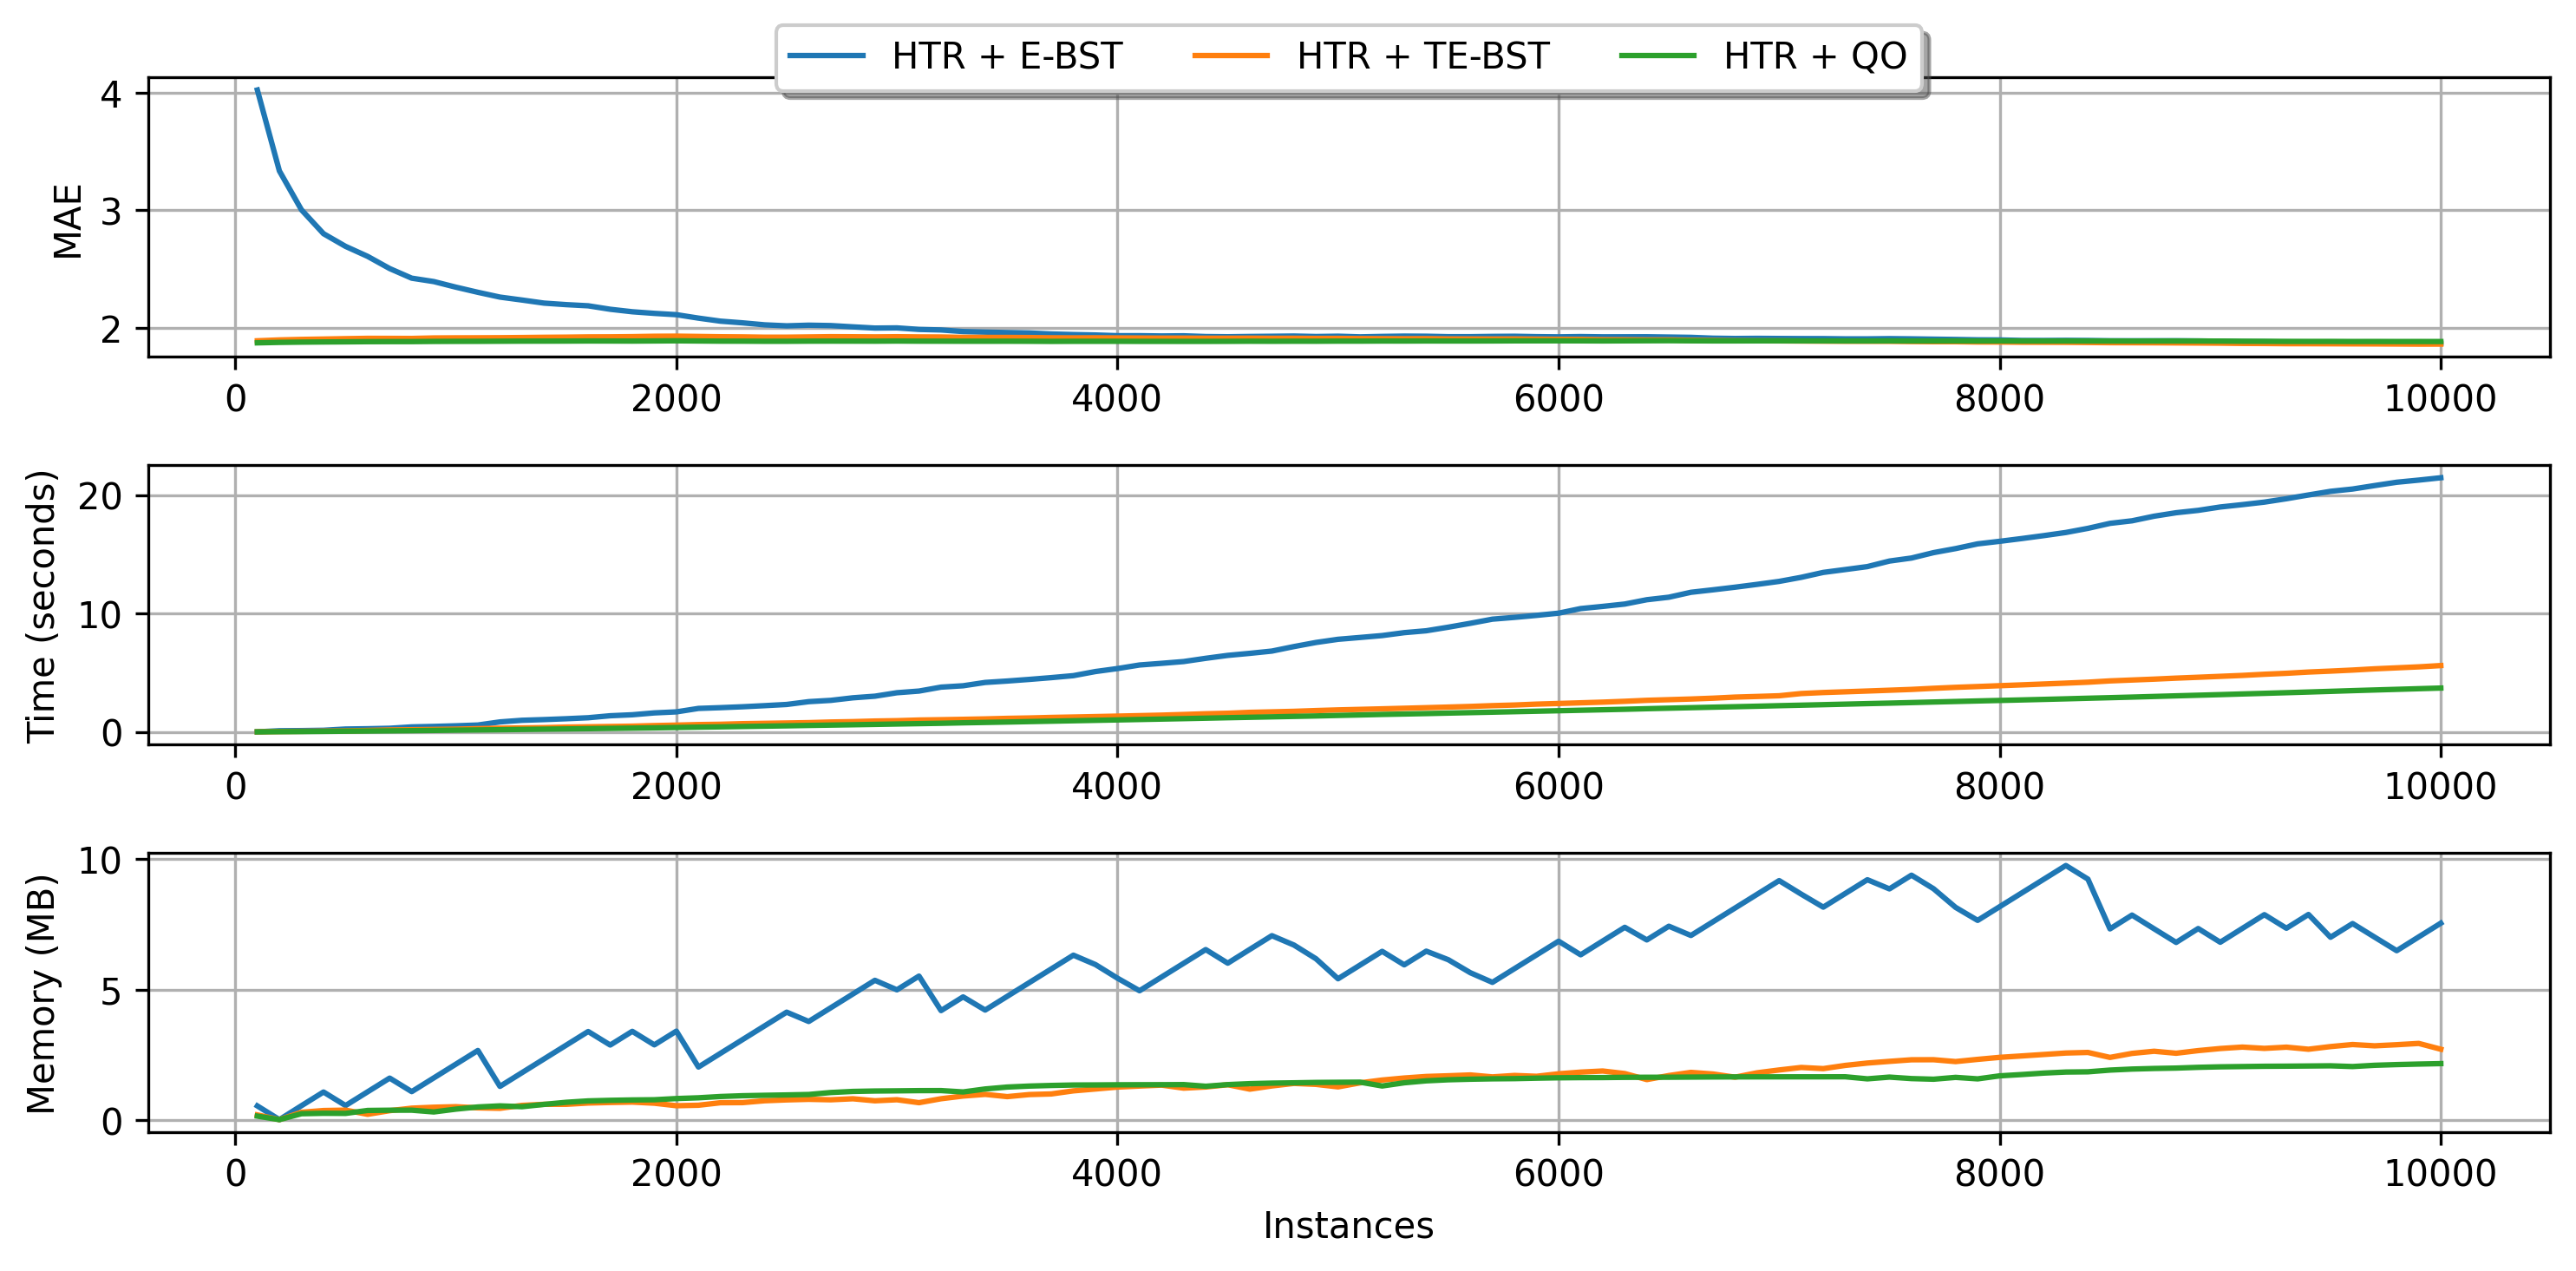

In [14]:
plot_oml_iter_progressive(res_1)